In [26]:
import pandas as pd
import io
import requests
import io
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.relativedelta import relativedelta

Lo hago con los datos dirctos anuales porque los mensuales estan truncado y existe una dirfereica al sumarlos para hacerlos anuales. En este caso la inflacion es la inflacion anual que habr[a a partir de la fecha indicada

In [29]:
post_infla = {'formatoCSV.x': '22',
             'series': 'SP30578',
             'version': '2'}
url = 'http://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?accion=consultarSeries'
inflacion_cont = '\n'.join(requests.post(url, data=post_infla).content.split('\n')[12:])
inflacion_data =pd.read_csv(io.StringIO(inflacion_cont.decode('utf-8')), names=['fecha', 'inflacion'], na_values='N/E')
inflacion_data['fecha'] = inflacion_data.fecha.map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') - relativedelta(months=11))
inflacion_data.set_index('fecha', inplace=True)
inflacion_data['inflacion'] = inflacion_data.inflacion.astype(float)

In [39]:
post_cetes = {'formatoCSV.x': '54',
             'series': 'SF43945',
             'version': '2'}
cetes_cont = '\n'.join(requests.post(url, data=post_cetes).content.split('\n')[12:])
cetes_data =pd.read_csv(io.StringIO(cetes_cont.decode('utf-8')), names=['fecha', 'cetes'], na_values='N/E')
cetes_data['fecha'] = cetes_data.fecha.map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y'))
cetes_data = cetes_data.loc[cetes_data.fecha > datetime.date(2002, 12, 31)]
cetes_data.set_index('fecha', inplace=True)
cetes_data['cetes'] = cetes_data.cetes.astype(float) * 0.84
cetes_data = cetes_data.resample('MS').mean()

In [40]:
result = inflacion_data.merge(cetes_data, left_index=True, right_index=True, how='inner')

count    162.000000
mean       0.081220
std        0.131063
min       -0.201133
25%       -0.000750
50%        0.044267
75%        0.180650
max        0.445933
Name: cetes_real, dtype: float64

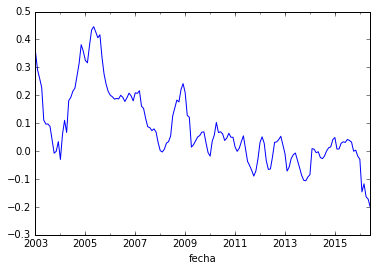

In [41]:
result['cetes_real'] = (result['cetes']-result['inflacion'])/12
result.cetes_real.plot()
result['cetes_real'].describe()

In [48]:
ipc_cetes = {'formatoCSV.x': '74',
             'series': 'SF4782',
             'version': '2',
             'tipoInformacion': '4,2'}
ipc_cont = '\n'.join(requests.post(url, data=ipc_cetes).content.split('\n')[12:])
ipc_data =pd.read_csv(io.StringIO(ipc_cont.decode('utf-8')), names=['fecha', 'ipc'], na_values='N/E')
ipc_data['fecha'] = ipc_data.fecha.map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y')  - relativedelta(months=11))
ipc_data.set_index('fecha', inplace=True)
ipc_data['ipc'] = ipc_data.ipc.astype(float)
ipc_data['ipc'] = ipc_data.ipc.rolling(window=12).sum()

In [49]:
ipc_data.tail()

,ipc
fecha,
2016-02-01,7.85
2016-03-01,7.35
2016-04-01,5.99
2016-05-01,7.68
2016-06-01,7.43


count    425.000000
mean       0.827231
std        3.340726
min      -10.559958
25%       -0.387275
50%        0.895792
75%        2.743933
max       12.580233
Name: ipc_real, dtype: float64

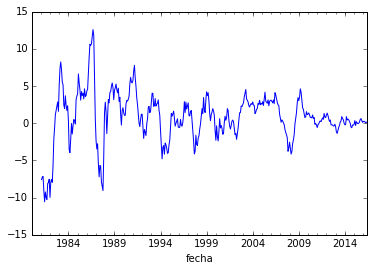

In [79]:
result_ipc = inflacion_data.merge(ipc_data, left_index=True, right_index=True, how='inner')
result_ipc['ipc_real'] = (result_ipc['ipc']*0.99-result_ipc['inflacion'])/12
result_ipc.ipc_real.plot()
result_ipc.ipc_real.describe()

In [51]:
import locale
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

'es_ES.UTF-8'

In [52]:
def two_year_to_full(x):
    partial = int(x)
    if partial < 67:
        result = 2000 + partial
    else:
        result = 1900 + partial
    return str(result)
def string_to_date(x):
    partial = x[-2:]
    date_string = x[:4] + two_year_to_full(partial)
    return datetime.datetime.strptime(date_string, '%b-%Y')

In [69]:
sura = pd.read_csv('../files/rendimientos_bolsa_basi_nomi_histo.csv', skiprows=9)
sura = sura.transpose().iloc[4:].reset_index().rename(columns={'index':'fecha', 0:'sura'})
sura['fecha'] = sura.fecha.map(lambda x: string_to_date(x) - relativedelta(months=11))
sura = sura.set_index('fecha')
sura['sura'] = ((sura.sura.astype(float)-1.03)/12).rolling(window=12).sum()


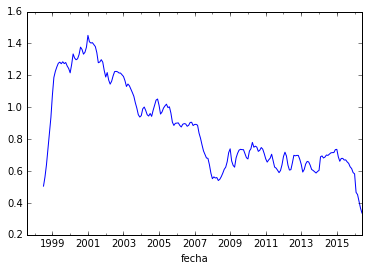

In [70]:
result_sura = inflacion_data.merge(sura, left_index=True, right_index=True, how='inner')
result_sura['sura_real'] = (result_sura['sura']-result_sura['inflacion'])/12
result_sura.sura_real.plot()

In [89]:
from scipy.optimize import curve_fit
import numpy as np
import random
def func(x, a, c, d):
    return a*np.exp(-c*x)+d

In [72]:
initial = 25
afore_data = result_sura[initial:]
data = np.array(afore_data.sura_real)
points_num = len(data)
p0=(2,0.005,1)
popt, pcov = curve_fit(func, range(points_num), data, p0)

In [73]:
popt

array([ 0.98569642,  0.01134941,  0.47297073])

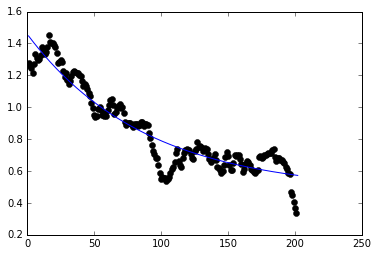

In [74]:
xx = np.linspace(1, points_num, points_num)

yy = func(xx, *popt)
plt.plot(range(points_num), data, 'ko')
plt.plot(xx,yy)

In [75]:
afore_data['ajuste'] = yy
afore_data['delta'] = afore_data.sura_real - afore_data.ajuste
afore_data.delta.describe()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


count    202.000000
mean       0.004387
std        0.088172
min       -0.236351
25%       -0.036024
50%        0.017830
75%        0.065412
max        0.165194
Name: delta, dtype: float64

## Aqui comienza el analisis
Las constantes encontradas son:

In [80]:
print('Cetes: mediana = ' + str(result['cetes_real'].median()) + ', std = ' + str(result['cetes_real'].std()))
print('IPC: mediana = ' + str(result_ipc.ipc_real.median()) + ', std = ' + str(result_ipc.ipc_real.std()))
print('SURA: mediana = ' + str(popt[-1]) + ', std = ' + str(afore_data.delta.std()))

Cetes: mediana = 0.0442666666667, std = 0.13106348251
IPC: mediana = 0.895791666667, std = 3.34072610156
SURA: mediana = 0.472970726441, std = 0.0881722567773


In [154]:
ret_payment = 19000
ret_age = 63
til_age = 90
my_age = 30
afore_ratio = 0.8
my_balance = 9439+24074+5341+46153+6000
payment = 2183.28 + 59.52*2 + 3500
min_prob = 20
print('payment is ' + str(payment))

payment is 5802.32


In [150]:
N = (til_age - ret_age)*12
present_value = ret_payment * (1 - (1 + result['cetes_real'].median()/100)**(-N))/(result['cetes_real'].median()/100)
present_value

5733730.504829614

In [151]:
def simulate(rate, error, periods, initial, payment, size=1000):
    names = ['sim_' + str(x) for x in range(1, size +1)]
    sim_data = pd.DataFrame(columns=names)
    initials = [initial] * size
    sim_data.loc[0] = initials
    for per in xrange(1, periods+1):
        sim_data.loc[per] = sim_data.loc[per-1].apply(lambda x: (x*(1+random.gauss(rate, error))) + payment)
    
    return sim_data

hey = simulate(result['cetes_real'].median()/100,result['cetes_real'].std()/100, N , 5800000, -ret_payment, 2000)
np.percentile(hey.iloc[-1].values, min_prob)

-429.75877288593733

In [152]:
N = (ret_age-my_age)*12
afore_sim = simulate(popt[-1]/100,afore_data.delta.std()/100, N , initial*afore_ratio, payment*(afore_ratio), 2000)
cetes_sim = simulate(result['cetes_real'].median()/100, result['cetes_real'].std()/100, N , initial*(1-afore_ratio), payment*(1 - afore_ratio), 1000)

In [153]:
np.percentile(afore_sim.iloc[-1].values, min_prob) + np.percentile(cetes_sim.iloc[-1].values, min_prob)

5816478.3576867143